# Neural style transfer

- description: "Neural style transfer with PyTorch"
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [deep-learning, PyTorch, computer-vision, from scratch]
- image: images/Covers/2021_07_20.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# Neural style transfer

Neural style transfer is the application of deep learning to the task of texture transfer. The goal is to transfer some characteristics of a *style image* (e.g. a painting) onto a *content image*. The technique can be used for artistic purpose or to enhance the *content image* with missing information, e.g. in super-resolution applications. 

**NOTE: here insert an illustration**


Here, I will mostly follow the original implementation by [Gatys et al. (2016)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf), and complement it with several 
improvements suggested in the literature. In Gatys et al.'s algorithm the *content* and *style* images are passed through a pretrained convolutional neural network (e.g. VGG19). The feature maps that result from the various convolution operations contain increasingly abstract representations of the original images. Thus, working with feature maps rather the the original image offers a more flexible way of combining them. From these feature maps, the algorithm performs three steps:

1. feature inversion (see my previous [blogpost](https://abauville.github.io/blog/deep-learning/pytorch/computer-vision/from%20scratch/2021/07/16/feature-inversion.html))
2. style extraction
3. merging the *content image* with the style of the *style image*.

According to Wikipedia:  "In the visual arts, style is a "...distinctive manner which permits the grouping of works into related categories"[1] or "...any distinctive, and therefore recognizable, way in which an act is performed or an artifact made or ought to be performed and made".[2]" For the purpose of style transfer, however, we need to define the style of a single image. A way to describe is the ensemble of characteristic visual elements (colors, lines, shapes, ...) and their relation to each other. Mathematically, this definition of style is capture using a [Gram matrix](https://en.wikipedia.org/wiki/Gram_matrix) which is, essentially, a correlation matrix of the feature maps for a given layer.

The overall code architecture is identical to the [feature inversion algorithm](https://abauville.github.io/blog/deep-learning/pytorch/computer-vision/from%20scratch/2021/07/16/feature-inversion.html), with added functionality for computing gram matrices, and to compute losses with respect to both the content image and the style image.

References: 
- [1] Fernie, Eric. Art History and its Methods: A critical anthology. London: Phaidon, 1995, p. 361. ISBN 978-0-7148-2991-3
- [2] Gombrich, 150

# Setup

We start by importing the necessary libraries

In [4]:
# Imports
import torch
import torchvision
from torch import nn
import skimage
from skimage import transform
from skimage import io
# from im_func import show_image, timer
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch.nn.functional as F
import torchvision.transforms.functional as TF

use_drive = True
if use_drive:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


# Image class

The image class handles, pre/post-processing and image augmentation (jittering, rotation).

In [5]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406]) # Fixed values for PyTorch pretrained models
rgb_std = torch.tensor([0.229, 0.224, 0.225])

class Image(nn.Module):
    def __init__(self, img=None, optimizable=True, img_shape=[64,64], jit_max=2, angle_max=2.0, shift_ini_i=0, shift_ini_j=0, random_seed=42):
        super(Image,self).__init__()
        
        self.img_shape = img_shape
        
        if type(img)==type(None):
            torch.manual_seed(random_seed)
            self.img = torch.rand([1, 3] + self.img_shape)
        else:
            self.img = img
            self.img = self.preprocess()
            self.img = self.jitter_transform(self.img,0,shift_ini_i, shift_ini_j)
        if optimizable == True:
            self.img = nn.Parameter(self.img)
         
        self.jit_i = 0
        self.jit_j = 0
        self.jit_max = jit_max
        self.angle = 0.0
        self.angle_max = angle_max

        
    def preprocess(self):
        with torch.no_grad():
            transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToPILImage(),
                torchvision.transforms.Resize(self.img_shape),
                torchvision.transforms.ToTensor(),
            ])
            return transforms(self.img).unsqueeze(0)
            

    def postprocess(self):
        with torch.no_grad():
            img = self.img.data[0].to(rgb_std.device).clone()
            img.clamp_(0, 1)
            return torchvision.transforms.ToPILImage()(img.permute(1, 2, 0).permute(2, 0, 1))
          
    def jitter_transform(self,img,angle,jit_i, jit_j):
        return torchvision.transforms.functional.affine(img, angle=angle, translate=(jit_i/self.img_shape[1], jit_j/self.img_shape[0]), scale=1., shear=[0.0,0.0])
        
    def jittered_image(self):
        with torch.no_grad():
            jit_max = 2
            temp = np.random.standard_normal(2)*2.0
            self.jit_i += temp[0]
            self.jit_j += temp[1]

            self.angle += np.random.standard_normal(1)[0]*1.0
            self.angle = np.clip(self.angle,-self.angle_max,self.angle_max)
            self.jit_i, self.jit_j = np.clip([self.jit_i, self.jit_j],-self.jit_max,self.jit_max)#.astype(int)
            print(self.angle, self.jit_i, self.jit_j, temp)
            return self.jitter_transform(self.img.data,self.angle,self.jit_i, self.jit_j) 
        
    def forward(self, jitter=False):
        self.img.data.clamp_(0, 1)
        if jitter:
            return self.jittered_image().to(device)
        else:
            return self.img.to(device)
            

# Pretrained network

Here, I use the VGG16 network

In [6]:
pretrained_net = torchvision.models.vgg16(pretrained=True)#.features.to(device).eval()
display(pretrained_net.features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# SmallNet class

I subset the pretrained network to compute only the required layers and return the feature maps of a small selection of layers.

In [7]:
class SmallNet(nn.Module):
    def __init__(self, pretrained_net, last_layer):
        super(SmallNet,self).__init__()
        self.net= nn.Sequential(*([torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)] + 
                     [pretrained_net.features[i]
                            for i in range(last_layer + 1)])).to(device).eval()

        
    def forward(self, X, extract_layers, gram=False):
        # Passes the image X through the pretrained network and 
        # returns a list containing the feature maps of layers specified in the list extract_layers
        detach = not(X.requires_grad) # We don't want to keep track of the gradients on the content image
        feature_maps = {}
        for il in range(len(self.net)):
            X = self.net[il](X)
            if (il-1 in extract_layers): # note: il-1 because I added a normalization layer before the pretrained net in self.net
                if detach:
                    feature_maps[il-1] = X.clone().detach()
                else:
                    feature_maps[il-1] = X.clone()
        return feature_maps

# Losses class

Losses include:

- *content loss*: mean squared error (MSE) between the feature maps of the content image and the ones of the generated image. 
- *style loss*: MSE between Gram matrices of style and generated images
- *intensity loss* and *total variation loss*: regularization to avoid spurious noise.

Loss can be computed with respect to  several *content* and *style* images at once. Using several images with affine transformations is another way to perform jittering. The inconvenient is that this approach takes more memory, but in exchange, all feature maps and grams matrices for the *content* and *style* images can be precomputed. I implemented the technique described into by [Berger and Memisevic (2015)](https://arxiv.org/abs/1606.01286) to improve the long range consistency of the style inversion. In this technique, additional gram matrices between shifted feature maps are performed to take into account the spatial correlation among feature maps.

In [8]:
class Losses(nn.Module):
    def __init__(self, img_ref, 
                 content_weight=1.0, style_weight=1.0, tv_weight=0.0, int_weight=0.0, 
                 alpha=6, beta=1.5):
        # img_ref is used to compute a reference total variation and reference intensity
        # tv_weight: weight of the total variation regularizer
        # int_weight: weight of the intensity regularizer
        # alpha: exponent for the intensity regularizer
        # beta: exponent for the total variation regularizer
        super(Losses,self).__init__()
        self.content_weight = content_weight
        self.style_weight   = style_weight
        self.tv_weight      = tv_weight
        self.int_weight     = int_weight

        self.content_loss   = 0.0
        self.style_loss     = 0.0
        self.tv_loss        = 0.0
        self.int_loss       = 0.0
        self.total_loss     = 0.0

        self.last_content_loss   = 1e10
        self.last_style_loss     = 1e10
        self.last_tv_loss        = 1e10
        self.last_int_loss       = 1e10
        self.last_clamp_loss       = 0.0
        self.last_total_loss     = 1e10
        
        self.alpha          = alpha
        self.beta           = beta
        
        self.B, self.V      = self.get_regularizer_refs(img_ref)
      

    def get_content_loss(self, Y_hat, Y, reduction='mean'):
        # Mean squared error between generated and content image
        loss = 0
        count = 0
        for key, y in Y.items():
            if key in Y_hat.keys():
                y_hat = Y_hat[key]
                loss += F.mse_loss(y_hat, 
                             y.detach(),reduction=reduction)
                count += 1
        return loss/count

    def get_gram(self, feature_map, delta=0, dir=0):
        # delta is a translation for longd-distance cross correlation, see: https://arxiv.org/pdf/1606.01286.pdf
        # dir is the direction (0=x; 1=y) in which the cross correlation is computed
        a, b, c, d = feature_map.size()  # a=batch size(=1)
        pad = delta
        

        if delta==0:
            features = feature_map.view(a * b, c * d)  # resise F_XL into \hat F_XL
            # G = torch.mm(features, features.t())  # compute the gram product
            G = torch.mm(features, features.t())  # compute the gram product
        else: 
            if dir==0:
                fm_pad = F.pad(feature_map, [pad,pad,0,0])
                fm_minus_delta = fm_pad[:,:,pad-delta : pad-delta+c, :].clone()
                fm_plus_delta  = fm_pad[:,:,pad+delta : pad+delta+c, :].clone()
            elif dir==1:
                fm_pad = F.pad(feature_map, [0,0,pad,pad])
                fm_minus_delta = fm_pad[:,:,:, pad-delta : pad-delta+d].clone()
                fm_plus_delta  = fm_pad[:,:,:, pad+delta : pad+delta+d].clone()
            else: 
                raise ValueError(f"unknown dir {dir}, accepted values are 0 or 1")

            fm_minus_delta = feature_map.view(a * b, c * d)  # resise F_XL into \hat F_XL
            fm_plus_delta = feature_map.view(a * b, c * d)
            
            G = torch.mm(fm_minus_delta, fm_plus_delta.t())  # compute the gram product
        return G.div(a * b * c * d)
   
    
    def get_style_loss(self, Y_hat, Y, reduction='sum', deltas=[], stride=1):
        # Y_hat is the generated image's feature map
        # Y is the style image's feature map
        loss = 0
        count = 0
        for key, y in Y.items():
            if key in Y_hat.keys():
                y_hat = Y_hat[key]

                G = self.get_gram(y_hat)
                A = self.get_gram(y)
                Lstyle = F.mse_loss(G, A.detach(),reduction='sum')
                Lcc = 0
                fac_sum = 1.0
                for i, delta in enumerate(deltas):
                    A_x = self.get_gram(y,delta=delta,dir=0)
                    A_y = self.get_gram(y,delta=delta,dir=1)
                    
                    fac = 1.0/(1.0+i) 
                    Lcc += fac * 0.5 * ( F.mse_loss(G, A_x.detach(),reduction='sum')
                                            + F.mse_loss(G, A_y.detach(),reduction='sum'))
                    fac_sum += fac

                loss += (Lstyle+Lcc)/fac_sum
                count += 1

        return loss/count
    
    def get_regularizer_refs(self, img):
        eps = 1e-10
        L2 = torch.sqrt(img[:,0,:,:]**2 + img[:,1,:,:]**2 + img[:,2,:,:]**2 + eps)
        B = L2.mean()

        d_dx = img[:,:,1:,:]-img[:,:,:-1,:]
        d_dy = img[:,:,:,1:]-img[:,:,:,:-1]
        L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2 + eps)
        V = L2.mean()
        return B, V

    def get_int_loss(self, img):
        # Intensity loss
        H = img.shape[2]
        W = img.shape[3]
        C = img.shape[1]
        eps = 1e-10
        L2 = torch.sqrt(img[:,0,:,:]**2 + img[:,1,:,:]**2 + img[:,2,:,:]**2 + eps)
        
        loss = 1./H/W/C/(self.B**self.alpha) * torch.sum(L2**self.alpha)
        
        return loss

    def get_tv_loss(self, img):
        # Total variation loss
        H = img.shape[2]
        W = img.shape[3]
        C = img.shape[1]
        eps = 1e-10 # avoids accidentally taking the sqrt of a negative number because of rounding errors

        # # total variation
        d_dx = img[:,:,1:,:]-img[:,:,:-1,:]
        d_dy = img[:,:,:,1:]-img[:,:,:,:-1]
        # I ignore the first row or column of the image when computing the norm, in order to have vectors with matching sizes
        # Thus, d_dx and d_dy are not strictly colocated, but that should be a good enough approximation because neighbouring pixels are correlated
        L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2 + eps)
        TV = torch.sum(L2**self.beta) # intensity regularizer

        loss = 1./H/W/C/(self.V**self.beta) * TV
#         loss = 1./H/W * (torch.sum(d_dx**2) + torch.sum(d_dy**2))
        return loss
    

    def forward(self,img,feature_map_gen, feature_map_content, feature_map_style, content_weights,style_deltas=[]):
        self.content_loss, w_sum = 0, 0
        for fm_content, w in zip(feature_map_content, content_weights):
                self.content_loss += self.get_content_loss(feature_map_gen, fm_content,reduction='mean')        
                w_sum += w
        self.content_loss /= w_sum

        self.style_loss, count = 0, 0
        for fm_style in feature_map_style:
            self.style_loss += self.get_style_loss(feature_map_gen, fm_style,reduction='sum',deltas=style_deltas)
            count += 1
        self.style_loss /= count

        self.int_loss = self.get_int_loss(img)
        self.tv_loss = self.get_tv_loss(img)
        
        self.total_loss = ( self.content_weight*self.content_loss
                    + self.style_weight*self.style_loss 
                    + self.int_weight*self.int_loss 
                    + self.tv_weight*self.tv_loss )
        
        
        return self.total_loss

# Device setup

In [9]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Training setup

Here, I create *content*, *style* and *generated* images by instantiating the `Image` class. I include several images for *content* to take into account local correlations (alternative to jittering the image). I also take one or several *style* images to extract characteristic features at different scales (see the Results section). I also initialize the optimizer, scheduler and loss functions.

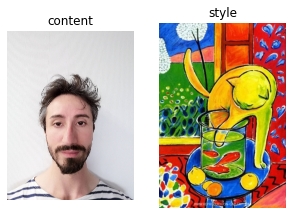

In [22]:
# Download images 
# ===================
content_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/IMG_20210617_094559.jpg?raw=true")
style_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/matisse_cat.jpeg?raw=true")

# Show
fig, ax = plt.subplots(1,2,figsize=[5,5])
plt.sca(ax[0])
plt.imshow(content_im); plt.title("content"); _ = plt.axis("off")
plt.sca(ax[1])
plt.imshow(style_im); plt.title("style"); _ = plt.axis("off")

# Choose layers
# ===================
content_layer = [7]
style_layers  = [2, 7, 14, 21, 28]

all_layers = list(set(content_layer+style_layers))
all_layers.sort()

# Generated image
# ===================
aspect_ratio = content_im.shape[1]/content_im.shape[0]
content_res = 512
# img_gen = Image(None, optimizable=True, img_shape=[content_res,int(content_res*aspect_ratio)]).to(device) # initialized with random noise
# img_gen = Image(None, optimizable=True, img_shape=[content_res,int(content_res*aspect_ratio)]).to(device) # initialized with random noise

# Style images
# ===================
style_list = []
style_res_ref = 256
for style_res in [style_res_ref]:
# for style_res in [128, 256, 512]:
    style_list.append(Image(img=style_im, optimizable=False, img_shape=[style_res, style_res],
                    shift_ini_i=0, shift_ini_j=0).to(device))

style_deltas = np.array([2, 4, 8, 16]) # relative shifts for the long range consistency algorithm of Berger and Memisevic (2015)

# Content images
# ===================
content_list = []
content_list_weights = []
count = 0
fm_content = []
for i in [-2,-1,0,1,2]:
    for j in [-2,-1,0,1,2]:
        content_list.append(Image(img=content_im, optimizable=False, img_shape=[content_res,int(content_res*aspect_ratio)],
                                    shift_ini_i=i, shift_ini_j=j).to(device))
        content_list_weights.append(1.0/(1.0+np.sqrt(i**2 + j**2)))
        if i==0 and j==0:
            content_ref = count
        count += 1
content_list_weights = np.array(content_list_weights) # relative importance of feature maps in the loss calculation


img_gen = Image(content_list[content_ref].img[0], optimizable=True, img_shape=[content_res,int(content_res*aspect_ratio)]).to(device) # initialized with random noise# SmallNet

# Neural network
# ===================
net = SmallNet(pretrained_net, all_layers[-1])

# Precompute feature maps
# ===================
fm_style = [net(img_s(), style_layers) for img_s in style_list]
fm_content = [net(img_c(), content_layer) for img_c in content_list]

# Losses
# ===================
loss_fn = Losses(style_list[0](),
                 content_weight = 0.6,
                 style_weight = 1.0,
                 tv_weight=20.0, 
                 int_weight=0.5)

# Optimizer, scheduler
# ===================
optimizer = torch.optim.LBFGS(img_gen.parameters(),lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
abs_loss_limit = 1e-3
rel_loss_limit = 1e-7

# Training

Here, I optimize the *generated* image and visualize the results.

In [23]:
fig, ax = plt.subplots(1,1,figsize=[10,10])
optimizer = torch.optim.LBFGS(img_gen.parameters(),lr=0.1)
def closure():
    optimizer.zero_grad()
    fm_gen = net(img_gen(), all_layers)

    loss = loss_fn(img_gen(), fm_gen, fm_content, fm_style, 
                   content_list_weights, 
                   style_deltas=style_deltas)
    loss.backward()
    # nn.utils.clip_grad_norm_(img_gen.parameters(), 2.0)
    nn.utils.clip_grad_value_(img_gen.parameters(), clip_value=1.0)
    return loss

last_loss = 1e10
frame = 0
for i in range(101,201):
    optimizer.step(closure)
    scheduler.step()
    
    if i%5==0:
        with torch.no_grad():
            plt.clf()
#             plt.imshow(img_gen.postprocess())
            plt.imshow(img_gen.postprocess())
            
            plt.title(f"epoch {i:02}, content, tv, style, intensity losses:" + 
                      f"{loss_fn.content_weight*loss_fn.content_loss:.2e}, " + 
                      f"{loss_fn.style_weight*loss_fn.style_loss:.2e}, " + 
                      f"{loss_fn.tv_weight*loss_fn.tv_loss:.2e}, " +
                      f"{loss_fn.int_weight*loss_fn.int_loss:.2e}, " + 
                      f"total:{loss_fn.total_loss:.2e}, abs: {torch.abs(last_loss-loss_fn.total_loss):.2e}")

            clear_output(wait = True)
            display(fig)
            
            plt.savefig(f"/content/drive/MyDrive/00_Data_science/Neural_style_transfer/Output/res_{style_res_ref}/Frame{frame:05d}")
            frame += 1
        
            if loss_fn.total_loss<abs_loss_limit:
                clear_output(wait = True)
                print(f'success: absolute loss limit ({abs_loss_limit:.1e}) reached')
                break
            if torch.abs(last_loss-loss_fn.total_loss)<rel_loss_limit:
                clear_output(wait = True)
                print(f'stopped because relative loss limit ({rel_loss_limit:.1e})  was reached')
                break

            if loss_fn.total_loss.isnan():
                print(f'stopped because loss is NaN')
                break
                
    last_loss = loss_fn.total_loss

    

# Results

I perform several optimization with identic resolution of the *generated* and *content* images but different resolutions for the style image. As shown in the figure below, the style is expressed as patterns whose characteristic scale is proportional to the resolution. In the rightmost subfigure, I used three style images during the inversion to obtain patterns of different scales.

<figure>
    <img src="https://github.com/abauville/blog/raw/master/images/2021_07_20_neural_style_transfer/Figure_01.png" alt='neural style transfer with different style resolutions' />
    <figcaption>Fig. 1. Results of the neural style transfer optimization using different resolutions of the style image. The characteristic scale of patterns is proportional to the style image's resolution. For the rightmost panel, three images were used simultaneously. </figcaption>
</figure>



# Conclusion

In this post, I implemented the neural style transfer algorithm of [Gatys et al. (2015)](https://arxiv.org/abs/1412.0035), with the improvements for feature inversion proposed by [Mahendran and Vedaldi (2016)](https://arxiv.org/abs/1512.02017) and long-range consistency improvements proposed [Berger and Memisevic (2015)](https://arxiv.org/abs/1606.01286) for the style computation. I reused the code architecture that I described in a previous blogpost on the [feature inversion algorithm](https://abauville.github.io/blog/deep-learning/pytorch/computer-vision/from%20scratch/2021/07/16/feature-inversion.html). Neural style transfer is a lot of fun to play with, although the algorithm implemented here is computationally expansive. Later improvements fixed this issue by training an additional network to learn the inversion process (e.g. [Johnson et al. (2016)](https://cs.stanford.edu/people/jcjohns/eccv16/).